In [139]:
import numpy as np
import pandas as pd
import scipy.special as sp
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

from src.mie_coef_acoustics import *

In [140]:
def plotSpectrum(k, a, rho_rel, beta_rel, nmin=0, nmax=10):
    sigma_sc, multipoles = sigmaSc_func(k, a, rho_rel, beta_rel, nmin=nmin, nmax=nmax)
    sigma_geom = np.pi * a**2
    Q_sc = sigma_sc / sigma_geom
    Q_multipoles = multipoles / sigma_geom
    
    plt.plot(a*k, Q_sc, lw=2, c="k")
    for n in range(nmin, nmax+1):
        plt.plot(a*k, Q_multipoles[n])
    plt.xlabel("Size parameter, $ka$")
    plt.ylabel("Cross section, $\sigma_{\mathrm{sc}} / \sigma_{\mathrm{geom}}$")
    #plt.margins(x=0)
    plt.show()

In [141]:
rho0 = 1
beta0 = 1

rho1 = 2
beta1 = 3

k = 1
a = np.linspace(0.01, stop=6, num=300)

nmin = 0
nmax = 10

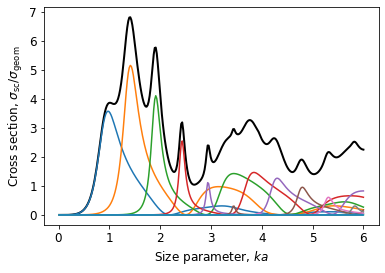

In [142]:
delta = 0.01
plotSpectrum(k, a, rho1/rho0 * (1 + 1j*delta), beta1/beta0 * (1 + 1j*delta))

In [143]:
prms_df = pd.read_csv("data/acoustic_material_prms.csv")

material_name_array = [prms_df['Material'][i] for i in range(len(prms_df))]
density_array = np.array([prms_df.to_numpy()[:, 1][i] for i in range(len(prms_df))])
c_sound_array = np.array([prms_df.to_numpy()[:, 2][i] for i in range(len(prms_df))])
compressibility_array = 1/(density_array * c_sound_array**2)

prms_df

,Material,Density [kg/m^3],Speed of sound [m/s]
0,air,1.2754,343.0
1,water,997.0000,1500.0
2,pSi,1040.0000,15.7
3,resin,1050.0000,2200.0
4,aerogel,70.0000,100.0


In [144]:
def plotOneInAnother(k, a, particle_index, host_index, nmin=0, nmax=10, delta=0.00):
    rho_rel = density_array[particle_index] / density_array[host_index] * (1 + 1j*delta)
    beta_rel = compressibility_array[particle_index] / compressibility_array[host_index] * (1 + 1j*delta)
    
    sigma_sc, multipoles = sigmaSc_func(k, a, rho_rel, beta_rel, nmin=nmin, nmax=nmax)
    sigma_geom = np.pi * a**2
    Q_sc = sigma_sc / sigma_geom
    Q_multipoles = multipoles / sigma_geom
    
    plt.figure()
    plt.title("{} in {}".format(material_name_array[particle_index], material_name_array[host_index]))
    plt.plot(a*k, Q_sc, lw=2, c="k")
    for n in range(nmin, nmax+1):
        plt.plot(a*k, Q_multipoles[n], '--')
    plt.xlabel("Size parameter, $ka$")
    plt.ylabel("Cross section, $\sigma_{\mathrm{sc}} / \sigma_{\mathrm{geom}}$")
    plt.yscale('log')
    plt.ylim(bottom=1e-10, top=np.max(Q_sc)*1.6)
    plt.xlim(left=0, right=np.max(a*k))
    plt.show()

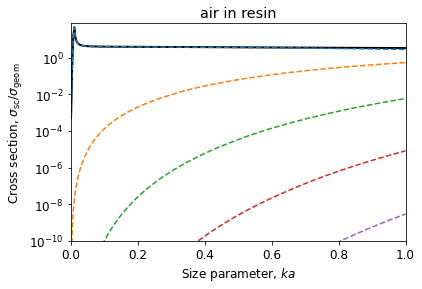

In [145]:
a = np.linspace(0.001, stop=1, num=300)
plotOneInAnother(k, a, 0, 3, delta=0.1)

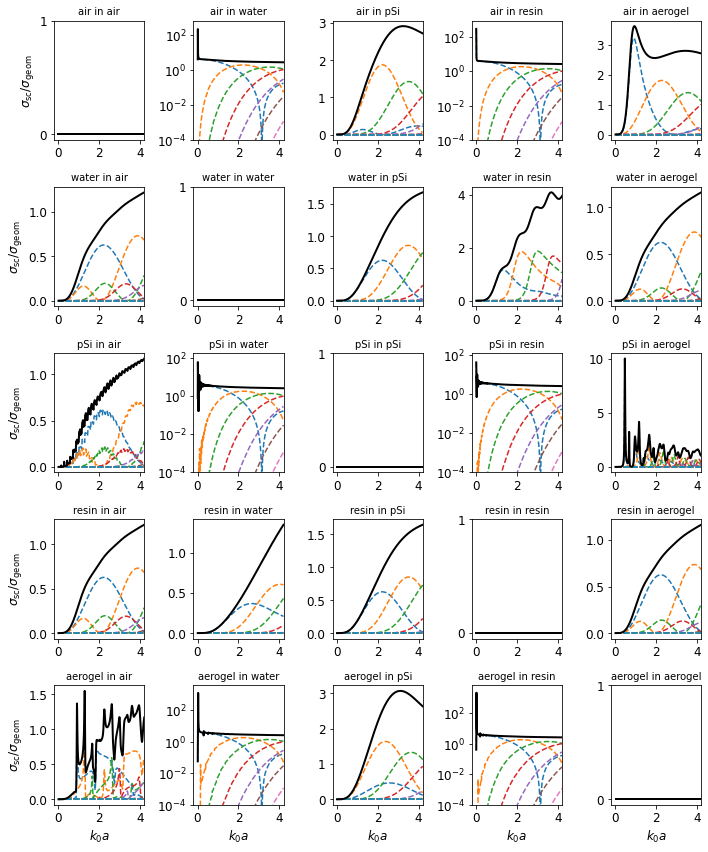

In [159]:
k = 1
a = np.linspace(0.01, stop=4.2, num=800)

nmin = 0
nmax = 50

N = len(prms_df)
rows, cols = N, N

delta = 0.01


fig, axs = plt.subplots(rows, cols)
fig.set_figheight(12)
fig.set_figwidth(10)

for i in range(N):
    for j in range(N):
        rho_rel = density_array[i] / density_array[j]
        beta_rel = compressibility_array[i] / compressibility_array[j] 
        if i != j:
            rho_rel *= (1 + 1j*delta)
            beta_rel *= (1 + 1j*delta)
        
        sigma_sc, multipoles = sigmaSc_func(k, a, rho_rel, beta_rel, nmin=nmin, nmax=nmax)
        sigma_geom = np.pi * a**2
        Q_sc = sigma_sc / sigma_geom
        Q_multipoles = multipoles / sigma_geom

        
        for n in range(nmin, nmax+1):
            if (i == 0) & (j == 0):
                if n < 7:
                    axs[i, j].plot(a*k, Q_multipoles[n], '--', label='n={}'.format(n))
                else:
                    axs[i, j].plot(a*k, Q_multipoles[n], '--')
            else:
                axs[i, j].plot(a*k, Q_multipoles[n], '--')
        axs[i, j].plot(a*k, Q_sc, lw=2, c="k")
        axs[i, j].set_title("{} in {}".format(material_name_array[i], material_name_array[j]), fontsize=10)
        axs[i, j].set_xlim(left=-0.2, right=np.max(a*k))
        #if (i==0) & (j==0):
            # axs[i, j].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=8)
        if i == j:
            axs[i, j].set_ylim((-0.05, 1))
            axs[i, j].set_yticks([0, 1])
        axs[i, j].set_xticks([0, 2, 4])
        if np.max(Q_sc) > 15:
            axs[i, j].set_yscale('log')
            axs[i, j].set_ylim(bottom=1e-4, top=np.max(Q_sc)*3)
        if i == N-1:
            axs[i, j].set_xlabel("$k_0 a$")
        if j == 0:
            axs[i, j].set_ylabel("$\sigma_{\mathrm{sc}} / \sigma_{\mathrm{geom}}$")
                
                
        #axs[i, j].set_title("{} in {}".format(i, j))

fig.tight_layout()
fig.savefig('all_cross_sections.svg')